<a href="https://colab.research.google.com/github/creepereye1204/HomeWork/blob/main/20230406/%EC%A0%84%EC%9D%B4%ED%95%99%EC%8A%B5_lr%3D0_00001.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install kaggle

In [2]:

from sklearn.model_selection import train_test_split

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [14]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

In [ ]:
from google.colab import files
files.upload()

In [16]:
!kaggle competitions download -c plant-pathology-2021-fgvc8

100% 14.9G/14.9G [02:22<00:00, 159MB/s]
100% 14.9G/14.9G [02:22<00:00, 112MB/s]


In [6]:
import os
os.mkdir('/content/train')
os.mkdir('/content/test')
os.mkdir('/content/eval')

In [ ]:
!unzip /content/plant-pathology-2021-fgvc8.zip -d /content/

In [20]:
import pandas as pd

In [21]:
train=pd.read_csv('/content/train.csv')

In [22]:
for dir in ['complex', 'frog_eye_leaf_spot', 'healthy', 'powdery_mildew', 'rust', 'scab']:
  os.makedirs('/content/train/'+dir)
  os.makedirs('/content/test/'+dir)
  os.makedirs('/content/eval/'+dir)

In [23]:
new=pd.DataFrame(columns=['image','labels'])
for idx,(image,label) in enumerate(train.values):
  n=len(label.split())
  if n!=1:
    cols= ['image','labels']	
    
    add_row = [[image,'complex']]	

    row_df = pd.DataFrame(data = add_row, columns = cols)	
                          
    new = pd.concat([new, row_df], ignore_index = True)
    train.drop(labels=idx,axis=0,inplace=True)

In [24]:
train=pd.concat([new,train],ignore_index=True)

In [25]:
train,other=train_test_split(train,  train_size= 0.6, shuffle= True)
test,eval=train_test_split(other,  train_size= 0.5, shuffle= True)

In [26]:
import shutil
def move(data,where):
  path='/content/train_images/'
  for name,label in data.values:
    if os.path.exists(path+name):
        shutil.move(path+name,"/content/"+where+"/"+label+'/'+name)

In [27]:
for key,value in {'train':train,'test':test,'eval':eval}.items():
  move(value,key)

In [28]:
train['labels'].isnull().sum()

0

In [29]:
train['labels'].value_counts()

scab                  2898
healthy               2776
frog_eye_leaf_spot    1935
complex               1750
rust                  1110
powdery_mildew         710
Name: labels, dtype: int64

In [30]:
import matplotlib.pyplot as plt


<Axes: >

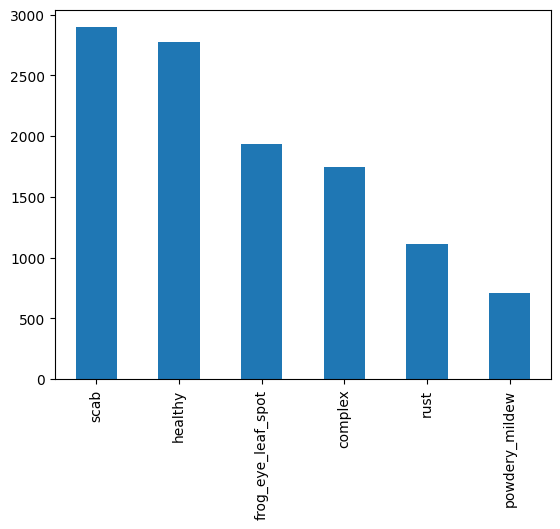

In [31]:
train['labels'].value_counts().plot(kind='bar')

In [32]:
len(train)

11179

In [33]:
test

,image,labels
381,aa9594ded2c95269.jpg,complex
10695,c5c606c3cfe3e2e0.jpg,scab
6,80ca8fea677591d1.jpg,complex
8279,b512dae909d6d4d4.jpg,healthy
12109,d0e1d895ce888cfb.jpg,complex
...,...,...
14841,e5b0969bdad9c908.jpg,frog_eye_leaf_spot
13859,ded8aa171cd205ab.jpg,frog_eye_leaf_spot
11519,ccbc3593c71ce226.jpg,healthy
3292,90ad3622716f799c.jpg,powdery_mildew


In [34]:
eval

,image,labels
14615,e3cfa6f0401368eb.jpg,frog_eye_leaf_spot
1983,84cb3a362cced993.jpg,healthy
2958,8d8f2cce34a593d2.jpg,frog_eye_leaf_spot
7530,afad762b8520fe20.jpg,frog_eye_leaf_spot
8973,baa48e75eaa38352.jpg,rust
...,...,...
10767,c6095651f4eb6d07.jpg,scab
2929,8d4abaa199759c6a.jpg,complex
4484,9a71889a93779996.jpg,healthy
1734,82b077dae06cab17.jpg,healthy


In [35]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision.datasets as datasets
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
import torch.optim as optim
import matplotlib.pyplot as plt
import numpy as np

In [36]:
nc = 3
nz = 100
ngf = 64
ndf = 64
num_epochs = 5
lr = 0.0002
beta1 = 0.5
ngpu = 1

In [37]:
if torch.cuda.is_available():
  device=torch.device('cuda')

trans_train=transforms.Compose([
    transforms.Resize((224,224)),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406],[0.229, 0.224, 0.225])
])
trans_test=transforms.Compose([
    transforms.Resize((224,224)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406],[0.229, 0.224, 0.225])
])
trans_eval=transforms.Compose([
    transforms.Resize((224,224)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406],[0.229, 0.224, 0.225])
])

train_data = datasets.ImageFolder(root='/content/train', 
                                    transform=trans_train,
                                   )
train_loader=DataLoader(dataset=train_data,batch_size=32,shuffle=True,drop_last=True,)

test_data = datasets.ImageFolder(root='/content/test', 
                                    transform=trans_test
                                   )
test_loader=DataLoader(dataset=test_data,batch_size=32,shuffle=True,drop_last=True)

eval_data = datasets.ImageFolder(root='/content/eval', 
                                    transform=trans_eval
                                   )
eval_loader=DataLoader(dataset=eval_data,batch_size=32,shuffle=True,drop_last=True)

In [38]:
import matplotlib.pyplot as plt
import numpy as np
import torchvision.utils as vutils
real_batch=next(iter(train_loader))

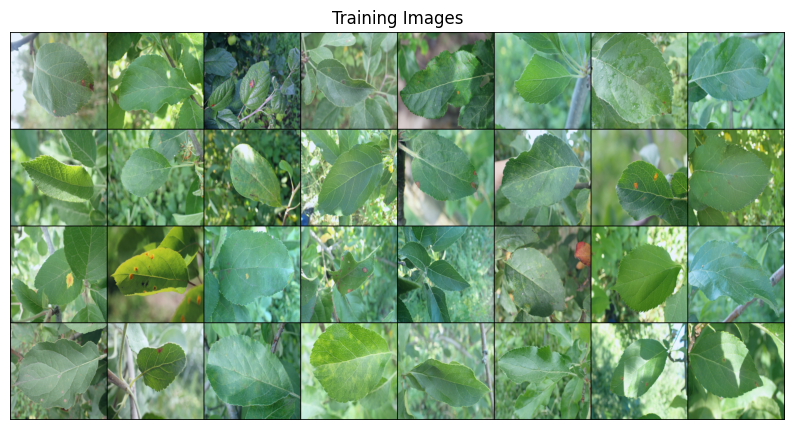

In [39]:
plt.figure(figsize=(10,10))
plt.axis('off')
plt.title('Training Images')
plt.imshow(np.transpose(vutils.make_grid(real_batch[0],padding=2,normalize=True).cpu(),(1,2,0)));

In [40]:
from torchvision import models
import torch.optim as optim

In [41]:
model_ft = models.resnet50(pretrained=True)
num_ftrs = model_ft.fc.in_features

model_ft.fc = nn.Linear(num_ftrs, 6)

model_ft = model_ft.to(device)

criterion = nn.CrossEntropyLoss()

optim = optim.Adam(model_ft.parameters(), lr=0.00001)


/usr/local/lib/python3.9/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth
100%|██████████| 97.8M/97.8M [00:01<00:00, 69.1MB/s]


In [ ]:
model_ft.load_state_dict(torch.load('/content/drive/MyDrive/Plant_Pathology_lr_changed_new.pth'))

In [43]:
def train(R,optim,cri):
 
  for epoch in range(3):
    for index,sample in enumerate(train_loader):
      x,y=sample
      X=x.to(device)
      Y=y.to(device)
      out=R(X)
      cost=criterion(out,Y)
      optim.zero_grad()
      cost.backward()
      optim.step()
      if index%10==0:
        print('epoch {} , cost: {:.4f}'.format(epoch,cost.item()))
        test(R,cri)
        R.train()
      torch.save(R.state_dict(),'/content/drive/MyDrive/Plant_Pathology_lr_changed_new.pth')

In [44]:
def test(R,cri):
  R.eval()
  correct=0
  loss_avg=0
  with torch.no_grad():
    for index,sample in enumerate(test_loader):
      x,y=sample
      X=x.to(device)
      Y=y.to(device)
      out=R(X)
      cost=criterion(out,Y)
      loss_avg+=cost.item()
      prediction=out.max(1,keepdim=True)[1]
      correct+=prediction.eq(Y.view_as(prediction)).sum().item()
      


  test_accuracy=100*correct/len(test_loader.dataset)
  loss_avg/=len(test_loader.dataset)
  print('cost: {:.2f}%'.format(test_accuracy))
  print('loss_avg:',loss_avg)

In [ ]:
train(model_ft,optim,criterion)

epoch 0 , cost: 1.9829
cost: 16.02%
loss_avg: 0.0583260943028342
epoch 0 , cost: 1.8235
cost: 17.34%
loss_avg: 0.055114384818576195
epoch 0 , cost: 1.7237
cost: 26.92%
loss_avg: 0.05214910205179686
epoch 0 , cost: 1.5840
cost: 43.80%
loss_avg: 0.04944336276763367
epoch 0 , cost: 1.4971
cost: 56.07%
loss_avg: 0.04668324885033051
epoch 0 , cost: 1.5409
cost: 61.62%
loss_avg: 0.04391398525212442
epoch 0 , cost: 1.2946
cost: 65.49%
loss_avg: 0.04136106360681711
epoch 0 , cost: 1.1038
cost: 68.57%
loss_avg: 0.03855291599236824
epoch 0 , cost: 1.4088
cost: 71.01%
loss_avg: 0.035504767764209744
epoch 0 , cost: 1.0496
cost: 72.71%
loss_avg: 0.03273011479272807
epoch 0 , cost: 1.0712
cost: 73.40%
loss_avg: 0.030177200426034112
epoch 0 , cost: 0.9671
cost: 74.99%
loss_avg: 0.02794899199191947
epoch 0 , cost: 0.9525
cost: 76.54%
loss_avg: 0.025836481548289873
epoch 0 , cost: 0.8199
cost: 77.99%
loss_avg: 0.023927595624345255
epoch 0 , cost: 0.9479
cost: 79.20%
loss_avg: 0.022425275669901587
epoch